In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_05 import *
torch.set_num_threads(2)

## ConvNet

In [3]:
x_train,y_train,x_valid,y_valid = get_data()

In [4]:
#export
def normalize_to(train, valid):
    m,s = train.mean(),train.std()
    return normalize(train, m, s), normalize(valid, m, s)

In [5]:
x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

In [6]:
x_train.mean(),x_train.std()

(tensor(3.0614e-05), tensor(1.))

In [7]:
nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [8]:
#export
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x): return self.func(x)

def flatten(x):      return x.view(x.shape[0], -1)

In [9]:
def mnist_resize(x): return x.view(-1, 1, 28, 28)

In [10]:
def get_cnn_model(data):
    return nn.Sequential(
        Lambda(mnist_resize),
        nn.Conv2d( 1, 8, 5, padding=2,stride=2), nn.ReLU(), #14
        nn.Conv2d( 8,16, 3, padding=1,stride=2), nn.ReLU(), # 7
        nn.Conv2d(16,32, 3, padding=1,stride=2), nn.ReLU(), # 4
        nn.Conv2d(32,32, 3, padding=1,stride=2), nn.ReLU(), # 2
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten),
        nn.Linear(32,data.c)
    )

In [11]:
model = get_cnn_model(data)

In [12]:
cbfs = [Recorder, partial(AvgStatsCallback,accuracy)]

In [13]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [14]:
%time run.fit(1, learn)

train: [2.25780328125, tensor(0.1622)]
valid: [1.9859787109375, tensor(0.3394)]
CPU times: user 5.74 s, sys: 117 ms, total: 5.86 s
Wall time: 1.97 s


## CUDA

In [15]:
#export
class CudaCallback(Callback):
    def begin_fit(self): self.model.cuda()
    def begin_batch(self): self.run.xb,self.run.yb = self.xb.cuda(),self.yb.cuda()

In [16]:
model = get_cnn_model(data)

In [17]:
cbfs.append(CudaCallback)

In [18]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [19]:
%time run.fit(3, learn)

train: [1.93797421875, tensor(0.3159, device='cuda:0')]
valid: [0.645898828125, tensor(0.7966, device='cuda:0')]
train: [0.3832334375, tensor(0.8835, device='cuda:0')]
valid: [0.2073767822265625, tensor(0.9411, device='cuda:0')]
train: [0.18911115234375, tensor(0.9435, device='cuda:0')]
valid: [0.1448433837890625, tensor(0.9601, device='cuda:0')]
CPU times: user 3.1 s, sys: 763 ms, total: 3.86 s
Wall time: 3.7 s


## Refactor model

In [20]:
def conv2d(ni, nf, ks=3, stride=2):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), nn.ReLU())

In [21]:
#export
class BatchTransformXCallback(Callback):
    _order=2
    def __init__(self, tfm): self.tfm = tfm
    def begin_batch(self): self.run.xb = self.tfm(self.xb)

def view_tfm(*size):
    def _inner(x): return x.view(*((-1,)+size))
    return _inner

In [22]:
mnist_view = view_tfm(1,28,28)

In [23]:
cbfs.append(partial(BatchTransformXCallback, mnist_view))

This model can now work on any size input:

In [24]:
nfs = [8,16,32,32]

In [25]:
def get_cnn_layers(data, nfs):
    nfs = [1] + nfs
    return [
        conv2d(nfs[i], nfs[i+1], 5 if i==0 else 3)
        for i in range(len(nfs)-1)
    ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def get_cnn_model(data, nfs): return nn.Sequential(*get_cnn_layers(data, nfs))

In [26]:
def get_runner(model, lr=0.6, cbs=None, loss_func = F.cross_entropy):
    opt = optim.SGD(model.parameters(), lr=lr)
    learn = Learner(model, opt, loss_func, data)
    return learn, Runner(cb_funcs=cbfs + listify(cbs))

In [27]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, lr=0.4)

In [28]:
run.fit(3, learn)

train: [2.13313578125, tensor(0.2166, device='cuda:0')]
valid: [0.987681640625, tensor(0.6767, device='cuda:0')]
train: [0.482231171875, tensor(0.8489, device='cuda:0')]
valid: [0.2825490966796875, tensor(0.9105, device='cuda:0')]
train: [0.20726349609375, tensor(0.9377, device='cuda:0')]
valid: [0.156196533203125, tensor(0.9530, device='cuda:0')]


## Hooks

### Manual insertion

In [29]:
GLOBAL_HIST_AMPLITUDE = 5
nBins = 200

def mkHist(x):
    #x should be a tensor..
    #hMin = torch.min(x).data #AutoScale
    #hMax = torch.max(x).data #AutoScale
    hMin = -GLOBAL_HIST_AMPLITUDE
    hMax = GLOBAL_HIST_AMPLITUDE
    ret = x.clone().detach().cpu()
    ret = ret.histc(nBins,hMin,hMax)
    return ret

In [30]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds  = [[] for _ in layers]
        self.act_hist  = [[] for _ in layers]
        
    def __call__(self, x):
        for i,l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(x.mean())
            self.act_stds [i].append(x.std ())
            self.act_hist[i].append(mkHist(x))
        return x
    
    def __iter__(self): return iter(self.layers)

In [31]:
model =  SequentialModel(*get_cnn_layers(data, nfs))
learn,run = get_runner(model, lr=0.9)

In [32]:
run.fit(2, learn)

train: [2.305566875, tensor(0.1312, device='cuda:0')]
valid: [2.3000380859375, tensor(0.0990, device='cuda:0')]
train: [1.363693125, tensor(0.5137, device='cuda:0')]
valid: [0.491172900390625, tensor(0.8631, device='cuda:0')]


- pct < x
- percentiles

tensor(1.0043) tensor(0.0028)


torch.Size([200])

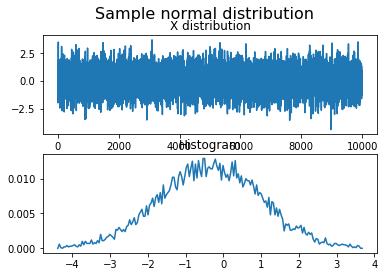

In [33]:
nItems = 10000

def getDistribution(m,s):
    fig, axs = plt.subplots(nrows=2, ncols=1)
    axs = axs.flatten()
    fig.suptitle('Sample normal distribution', fontsize=16)

    #x = torch.randn(nItems)
    x = torch.distributions.Normal(m,s).sample([nItems])
    axs[0].plot(x); axs[0].set_title(f'X distribution')
    hist = torch.histc(x, bins=nBins, min=-3*s, max=+3*s)
    hist = hist/nItems # normalize
    xh = np.linspace(min(x),max(x), nBins)
    axs[1].plot(xh,hist); axs[1].set_title(f'Histogram')
    print(x.std(), x.mean())
    hist = hist.float()
    return hist

histNormal = getDistribution(0,1)
histNormal.shape

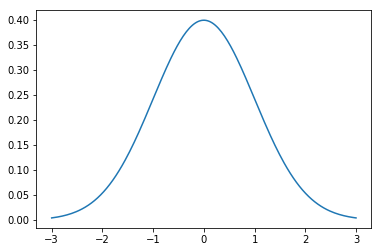

torch.Size([200])

In [34]:
# Real normal distribution
def displayIdealNormalDistribusion():
    import scipy.stats as stats

    mu = 0
    variance = 1
    sigma = math.sqrt(variance)
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, nBins)
    h = stats.norm.pdf(x, mu, sigma)
    plt.plot(x, h)
    plt.show()
    return h
    
idealNorm = displayIdealNormalDistribusion()
idealNorm = torch.tensor(idealNorm).float()
idealNorm.shape

In [35]:
# Divide a real normal distribution by an "ideal one"


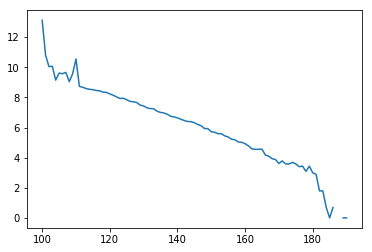

In [36]:
def viewFirstSlice(layer):
    x = layer[0]
    plt.plot(x.log())

viewFirstSlice(model.act_hist[0])

In [37]:
t=torch.randn([216, 200])
t.shape

torch.Size([216, 200])

In [38]:
t.max(dim=0)[0].shape

torch.Size([200])

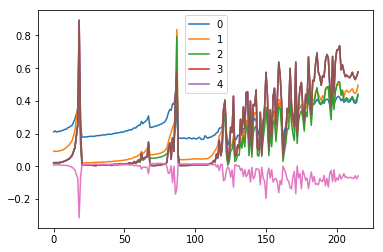

In [39]:
for l in model.act_means: plt.plot(l)
plt.legend(range(5));

In [40]:
GLOBAL_HIST_AMPLITUDE,nBins

(5, 200)

In [41]:
def getHistImg(h,m,showMean, alignSlices):
    m = torch.tensor(m)
    m_id = (((m+GLOBAL_HIST_AMPLITUDE)/(2*GLOBAL_HIST_AMPLITUDE))*nBins).int() #hist bin where we have the mean 
    m_id = torch.clamp(m_id,0,nBins-1) #Clamp to valid image pixels
    dd = torch.cat(h).view(len(h), h[0].shape[0])
    # dd = torch.nn.Softmax(0)(dd) # Constraint 01
    #dd = dd * 255 # Scale for visualizaion
    dd = dd.log() # Scale for visualizaion

    m_hVal = dd[range(len(m_id)),list(m_id)] #
    
    if alignSlices: dd = dd-(m_hVal.unsqueeze(1)) # Keep mean at max
    if showMean: dd[range(len(m_id)),list(m_id)] = dd.min() # Draws the mean
    
    dd = dd.t() # rotate
    dd = dd.flip(0) # Swap pos/neg Y
    return dd #return m_id for plot in histogram

def plotActHist(hists, means, cols=3, showMean=False, alignSlices=False):
    n=len(hists)
    cols = cols or 3
    rows = int(math.ceil(n/cols))
    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(20,10))
    fig.suptitle('Activations Y:log(histogram) X:batch', fontsize=16)
    axs = axs.flatten()

    for i,_ in enumerate(hists):
        l=hists[i]
        m=means[i]
        img=getHistImg(l,m,showMean,alignSlices)
        axs[i].imshow(img); 
        axs[i].set_title(f'Layer {i}')
        imgH=img.shape[0]
#        plt.set_yticks([0,imgH/2,imgH],(str(-GLOBAL_HIST_AMPLITUDE),'0',str(GLOBAL_HIST_AMPLITUDE)))
        axs[i].set_yticks([])
        axs[i].set_ylabel(str(-GLOBAL_HIST_AMPLITUDE) + " : " + str(GLOBAL_HIST_AMPLITUDE))
        imgW=img.shape[1]
        imgH=img.shape[0]
        axs[i].plot([0,imgW],[imgH/2,imgH/2],'r') # X Axis
        
    #plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)
        
    #Remove unused axes:
    for i in range(n,rows*cols):
        fig.delaxes(axs[i])

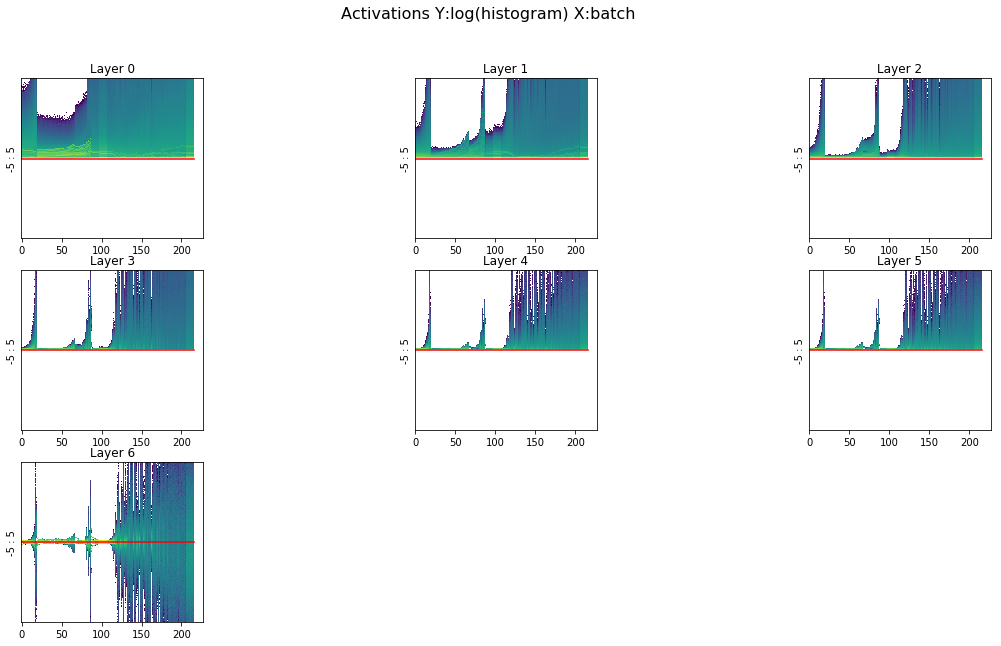

In [42]:
plotActHist(model.act_hist, model.act_means, cols=3, showMean=False)

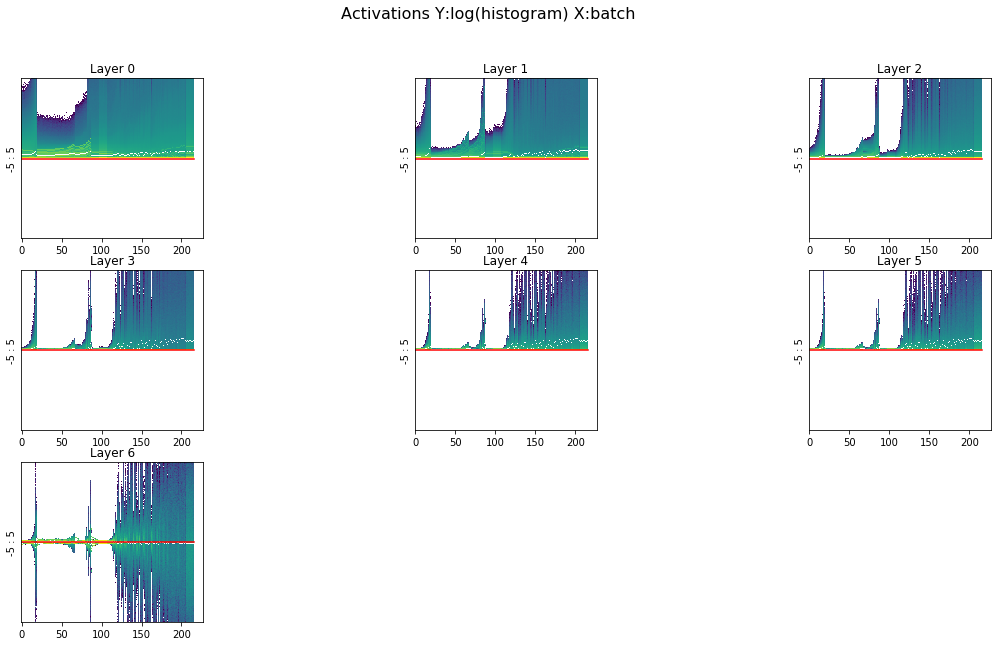

In [43]:
plotActHist(model.act_hist, model.act_means, cols=3, showMean=True)

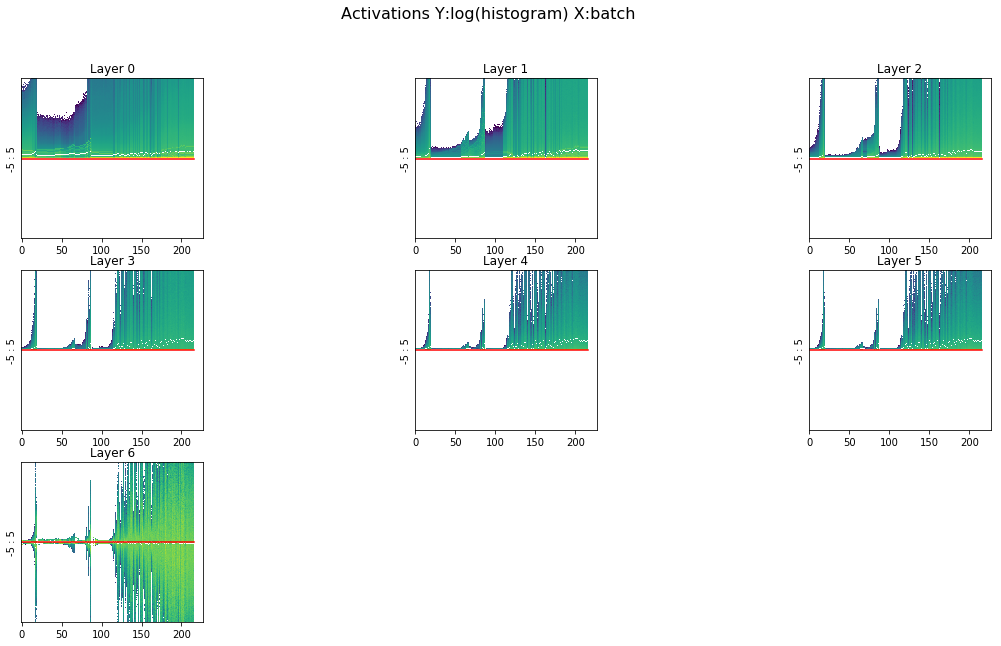

In [44]:
plotActHist(model.act_hist, model.act_means, cols=3, showMean=True, alignSlices=True)

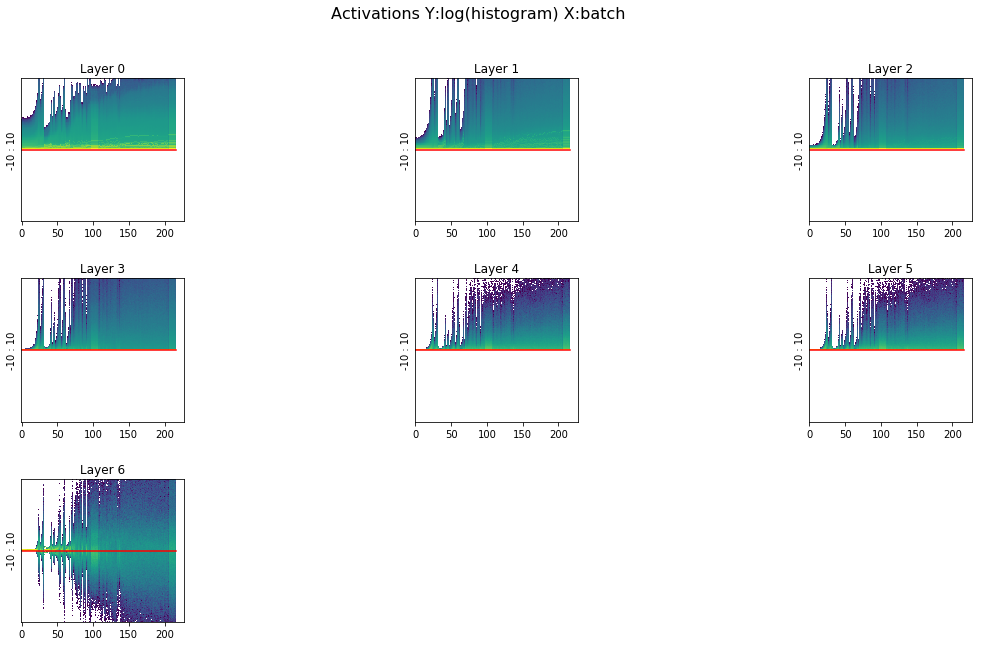

In [44]:
#Original
plotActHist(model.act_hist, cols=3)

tensor(0.2520, device='cuda:0', grad_fn=<MeanBackward1>)

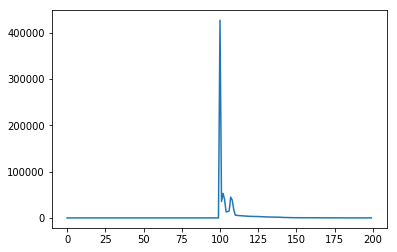

In [45]:
tt = model.act_hist[0][0]
plt.plot((tt))
model.act_means[0][0]

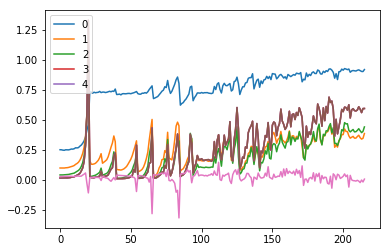

In [46]:
for l in model.act_means: plt.plot(l)
plt.legend(range(5));

In [47]:
m0 = torch.Tensor(model.act_means[0])
s0 = torch.Tensor(model.act_stds[0])

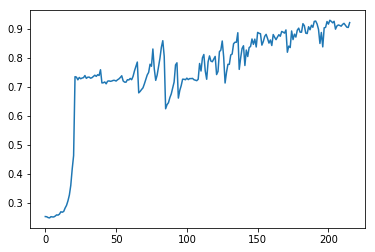

In [48]:
plt.plot(m0)

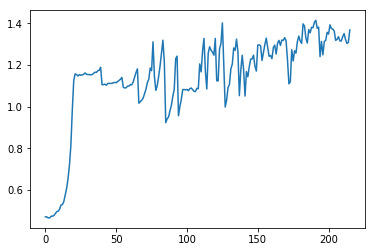

In [49]:
plt.plot(s0)

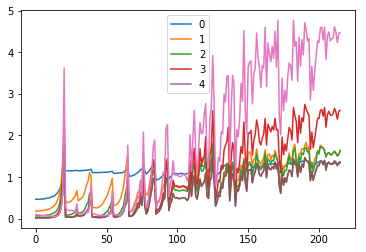

In [50]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(5));

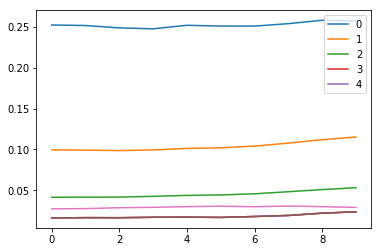

In [51]:
for l in model.act_means: plt.plot(l[:10])
plt.legend(range(5));

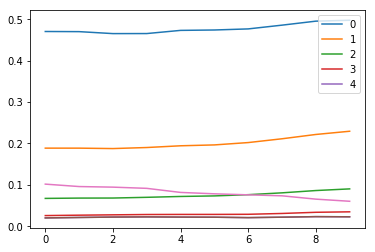

In [52]:
for l in model.act_stds: plt.plot(l[:10])
plt.legend(range(5));

### Pytorch hooks

In [53]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, lr=0.5)

In [54]:
act_means = [[] for _ in model]
act_stds  = [[] for _ in model]

In [55]:
def append_stats(i, mod, inp, outp):
    act_means[i].append(outp.mean())
    act_stds [i].append(outp.std())

In [56]:
for i,m in enumerate(model): m.register_forward_hook(partial(append_stats, i))

In [57]:
run.fit(1, learn)

train: [2.03181890625, tensor(0.2893, device='cuda:0')]
valid: [1.17402998046875, tensor(0.6079, device='cuda:0')]


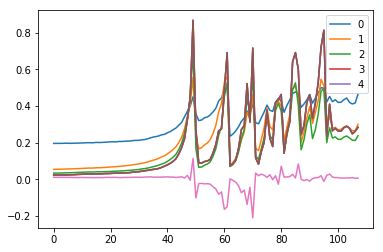

In [58]:
for o in act_means: plt.plot(o)
plt.legend(range(5));

### Hook class

In [58]:
#export
def children(m): return list(m.children())

class Hook():
    def __init__(self, m, f): 
        self.means = []
        self.stds  = []
        self.act_hist  = []
        self.hook = m.register_forward_hook(partial(f, self))
        
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

In [59]:
def append_stats(hook, mod, inp, outp):
    hook.means.append(outp.mean())
    hook.stds .append(outp.std())
    hook.act_hist.append(mkHist(outp))

In [60]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, lr=0.5)

In [61]:
hooks = [Hook(l, append_stats) for l in children(model[:4])]

In [62]:
run.fit(1, learn)

train: [1.62605734375, tensor(0.4425, device='cuda:0')]
valid: [0.582446142578125, tensor(0.8172, device='cuda:0')]


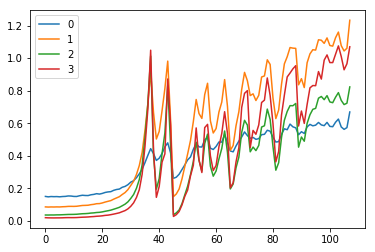

In [63]:
for h in hooks:
    plt.plot(h.means)
    h.remove()
plt.legend(range(4));

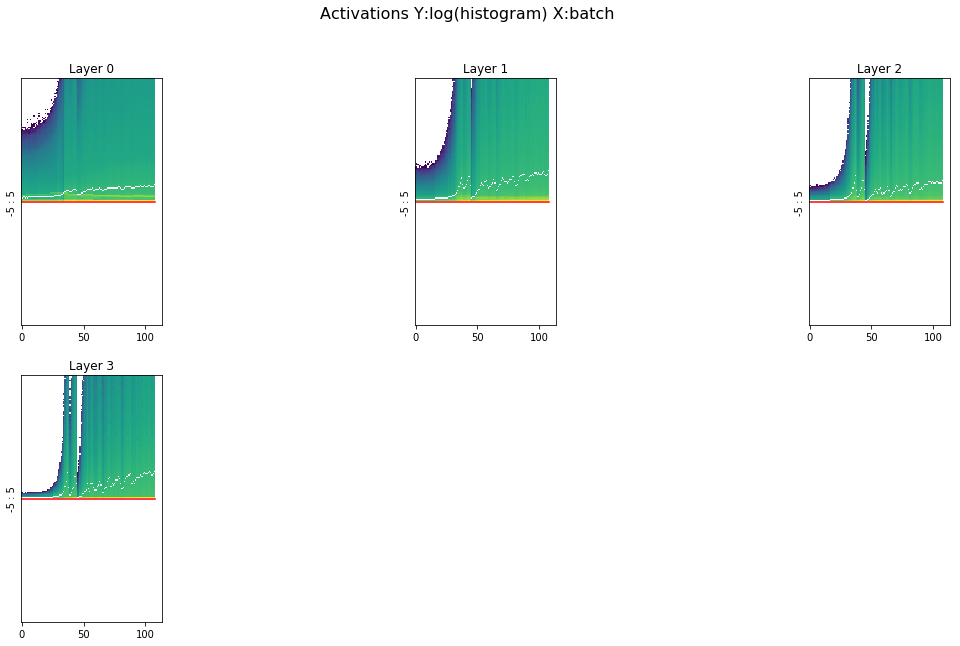

In [64]:
means=[h.means for h in hooks]
hists=[h.act_hist for h in hooks]
plotActHist(hists, means, cols=3, showMean=True, alignSlices=True)

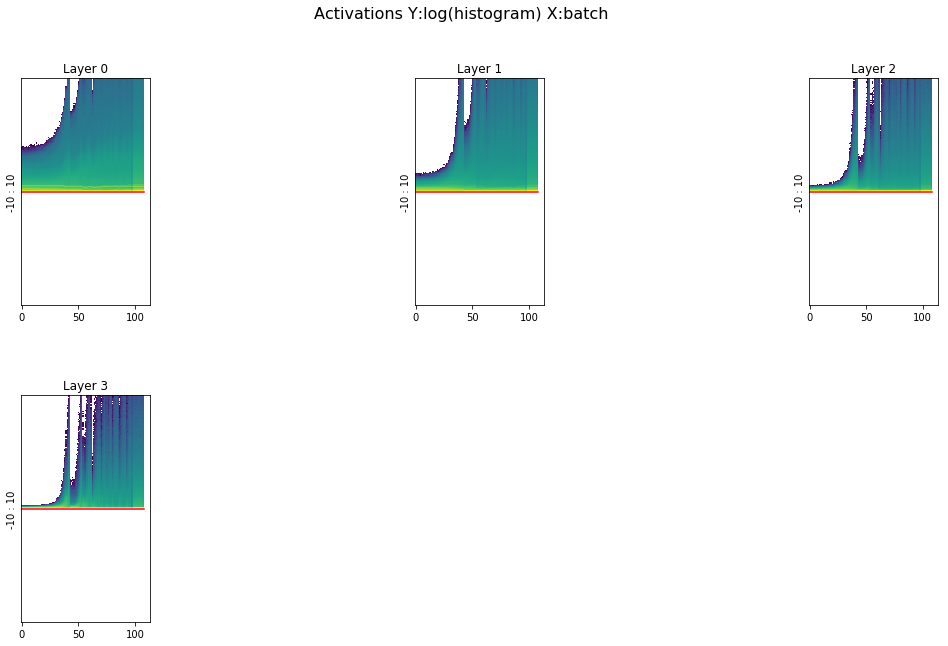

In [56]:
#ORIGINAL ONE...
hists=[h.act_hist for h in hooks]
plotActHist(hists)

### A Hooks class

In [66]:
#export
from torch.nn import init

class Hooks():
    def __init__(self, ms, f): self.hooks = [Hook(m, f) for m in ms]
    def __getitem__(self,i): return self.hooks[i]
    def __len__(self): return len(self.hooks)
    def __iter__(self): return iter(self.hooks)
    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.remove()
        
    def remove(self):
        for h in self.hooks: h.remove()

In [67]:
model = get_cnn_model(data, nfs).cuda()
learn,run = get_runner(model, lr=0.5)

In [68]:
x,y = next(iter(data.valid_dl))
x = mnist_resize(x).cuda()

In [69]:
x.mean(),x.std()

(tensor(-0.0127, device='cuda:0'), tensor(0.9849, device='cuda:0'))

In [70]:
p = model[0](x)
p.mean(),p.std()

(tensor(0.1766, device='cuda:0', grad_fn=<MeanBackward1>),
 tensor(0.3354, device='cuda:0', grad_fn=<StdBackward0>))

In [71]:
for l in model:
    if isinstance(l, nn.Sequential): init.kaiming_normal_(l[0].weight)

In [72]:
p = model[0](x)
p.mean(),p.std()

(tensor(0.4741, device='cuda:0', grad_fn=<MeanBackward1>),
 tensor(0.8630, device='cuda:0', grad_fn=<StdBackward0>))

train: [1.38650953125, tensor(0.5591, device='cuda:0')]
valid: [0.3698943115234375, tensor(0.8831, device='cuda:0')]


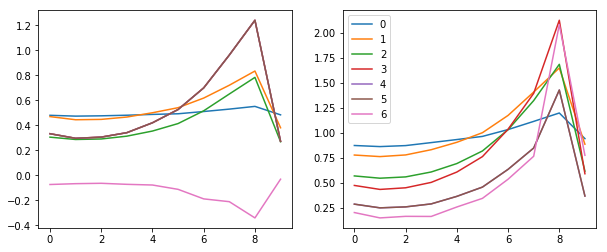

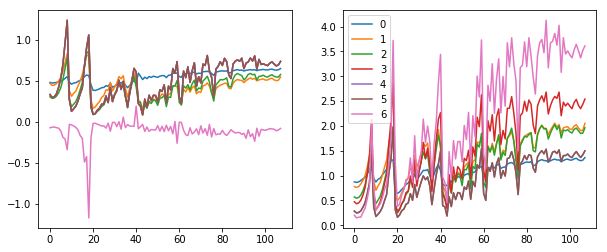

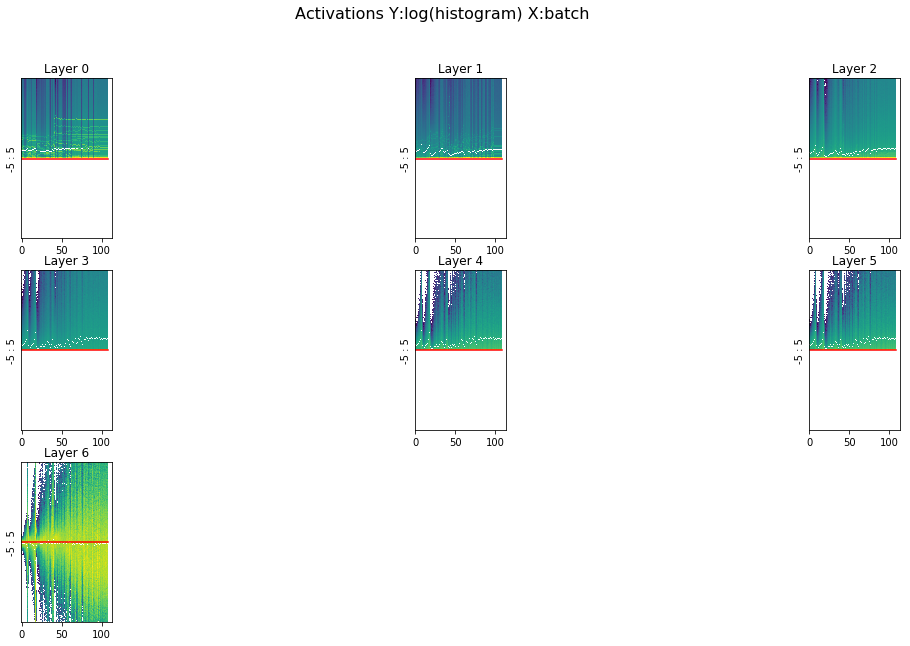

In [73]:
with Hooks(model, append_stats) as hooks:
    nl=len(hooks)
    run.fit(1, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ax0.plot(h.means[:10])
        ax1.plot(h.stds[:10])
        h.remove()
    plt.legend(range(nl));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ax0.plot(h.means)
        ax1.plot(h.stds)
    plt.legend(range(nl));
    
    means=[h.means for h in hooks]
    hists=[h.act_hist for h in hooks]
    plotActHist(hists, means, cols=3, showMean=True, alignSlices=True)

train: [1.255074375, tensor(0.5869, device='cuda:0')]
valid: [0.324934228515625, tensor(0.8933, device='cuda:0')]


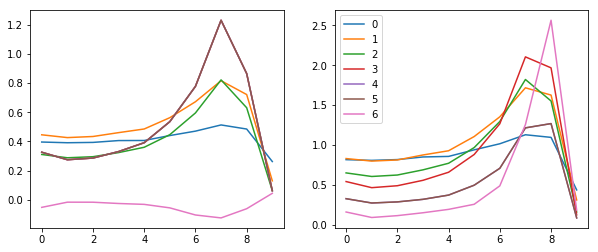

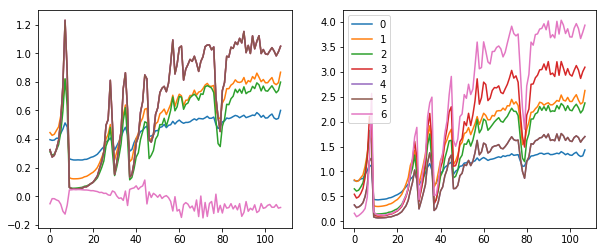

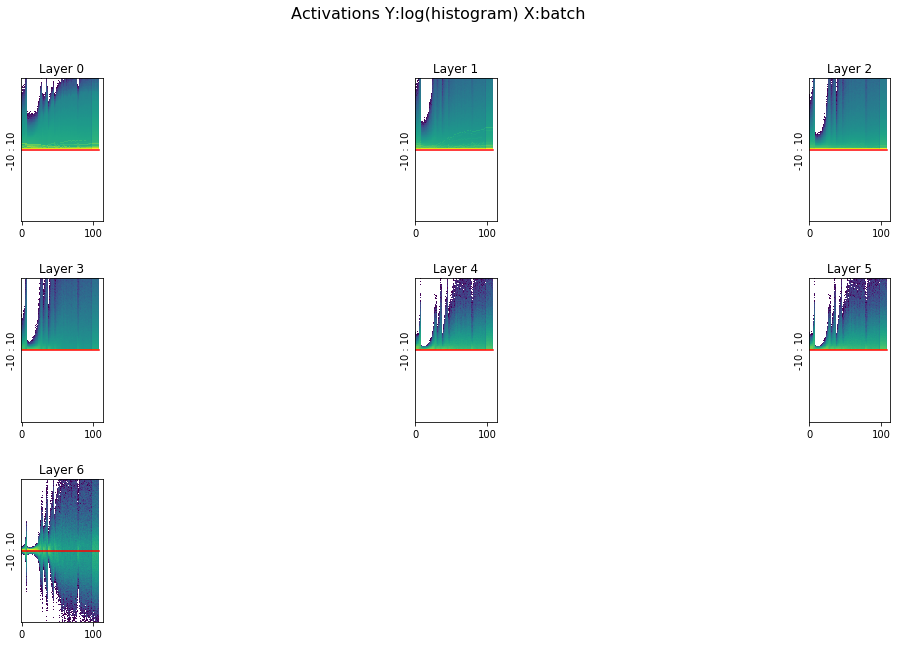

In [64]:
#Original
with Hooks(model, append_stats) as hooks:
    nl=len(hooks)
    run.fit(1, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ax0.plot(h.means[:10])
        ax1.plot(h.stds[:10])
        h.remove()
    plt.legend(range(nl));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ax0.plot(h.means)
        ax1.plot(h.stds)
    plt.legend(range(nl));
    
    plotActHist([h.act_hist for h in hooks])

## Generalized ReLU

In [74]:
#export
def get_cnn_layers(data, nfs, **kwargs):
    nfs = [1] + nfs
    return [conv2d(nfs[i], nfs[i+1], **kwargs)
            for i in range(len(nfs)-1)] + [
        nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def get_cnn_model(data, nfs, **kwargs): return nn.Sequential(*get_cnn_layers(data, nfs, **kwargs))

def conv2d(ni, nf, ks=3, stride=2, **kwargs):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), GeneralRelu(**kwargs))

class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv

    def forward(self, x): 
        x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x.sub_(self.sub)
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

In [75]:
model =  SequentialModel(*get_cnn_layers(data, nfs, leak=0.1, sub=0.4, maxv=6.))

for l in model:
    if isinstance(l, nn.Sequential): init.kaiming_normal_(l[0].weight, a=0.1)

learn,run = get_runner(model, lr=0.1)

train: [1.3208375, tensor(0.6264, device='cuda:0')]
valid: [0.481878369140625, tensor(0.8791, device='cuda:0')]
train: [0.4105676171875, tensor(0.8856, device='cuda:0')]
valid: [0.295040283203125, tensor(0.9186, device='cuda:0')]


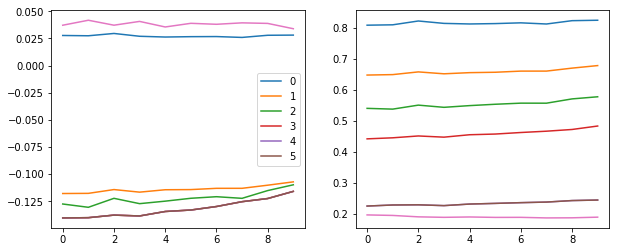

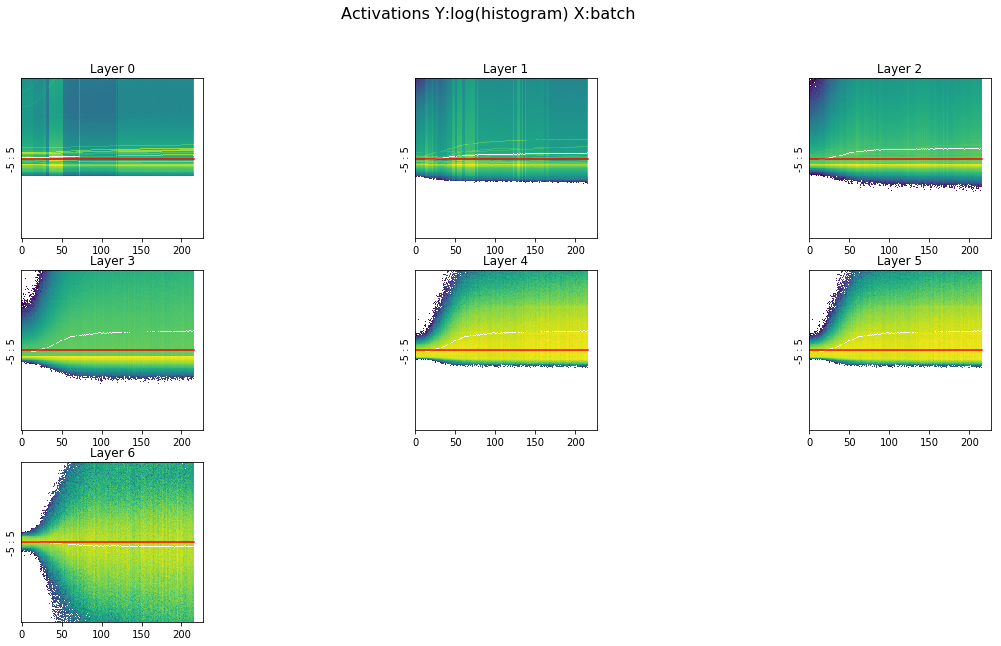

In [76]:
fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))

with Hooks(model, append_stats) as hooks:
    run.fit(2, learn)
    for h in hooks:
        ax0.plot(h.means[:10])
        ax1.plot(h.stds[:10])
    h.remove()
    ax0.legend(range(6));
    
    means=[h.means for h in hooks]
    hists=[h.act_hist for h in hooks]
    plotActHist(hists, means, cols=3, showMean=True, alignSlices=True)

train: [1.47939609375, tensor(0.5572, device='cuda:0')]
valid: [0.58348984375, tensor(0.8545, device='cuda:0')]
train: [0.4658346484375, tensor(0.8704, device='cuda:0')]
valid: [0.33234609375, tensor(0.9082, device='cuda:0')]


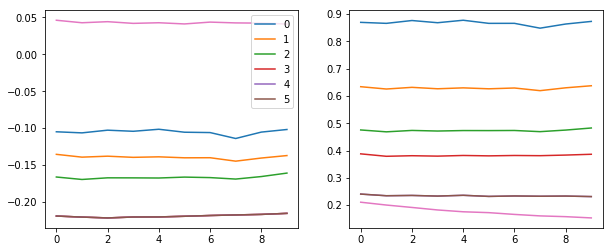

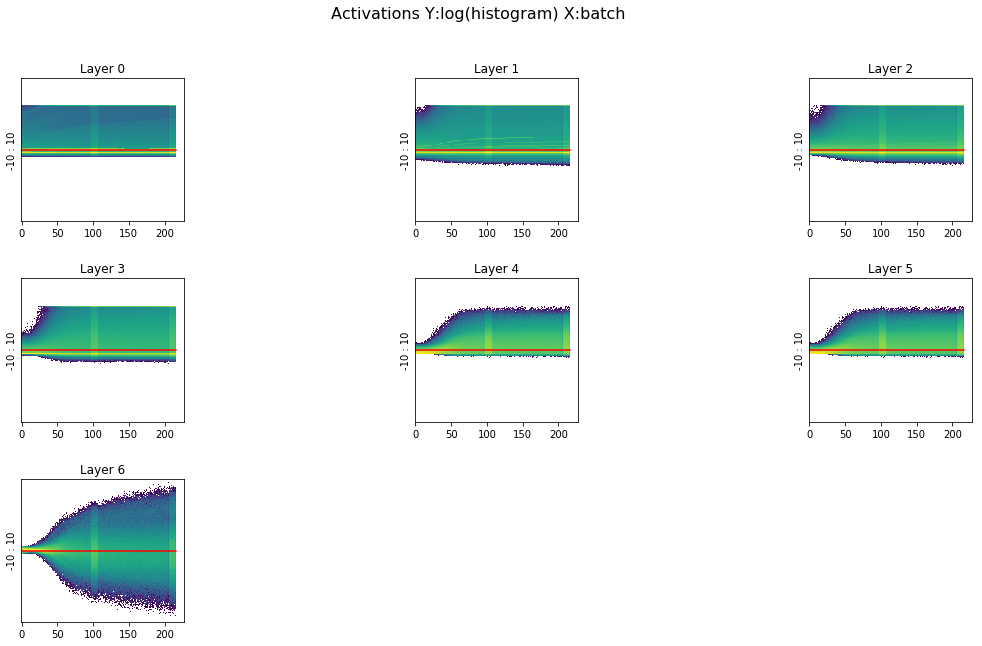

In [67]:
#Original
fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))

with Hooks(model, append_stats) as hooks:
    run.fit(2, learn)
    for h in hooks:
        ax0.plot(h.means[:10])
        ax1.plot(h.stds[:10])
    h.remove()
    ax0.legend(range(6));
    
    plotActHist([h.act_hist for h in hooks])

In [68]:
def init_cnn(m):
    for l in m:
        if isinstance(l, nn.Sequential):
            init.kaiming_normal_(l[0].weight, a=0.1)
            l[0].weight.data.mul_(1.1)

In [69]:
model =  SequentialModel(*get_cnn_layers(data, nfs, leak=0.1, sub=0.4, maxv=6.))
init_cnn(model)
learn,run = get_runner(model, lr=0.1)

train: [1.124404453125, tensor(0.6836, device='cuda:0')]
valid: [0.4614962890625, tensor(0.8833, device='cuda:0')]


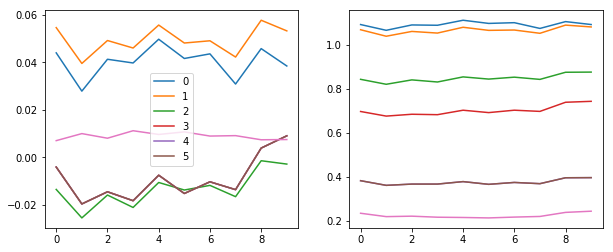

In [70]:
fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))

with Hooks(model, append_stats) as hooks:
    run.fit(1, learn)
    for h in hooks:
        ax0.plot(h.means[:10])
        ax1.plot(h.stds[:10])
    h.remove()
    ax0.legend(range(6));

In [71]:
def get_learn_run(nfs, lr, cbs=None):
    model =  SequentialModel(*get_cnn_layers(data, nfs, leak=0.1, sub=0.4, maxv=6.))
    init_cnn(model)
    return get_runner(model, lr=lr, cbs=cbs)

In [ ]:
sched = combine_scheds([0.3, 0.7], [sched_lin(0.2, 1.), sched_lin(1., 0.1)]) 

In [ ]:
learn,run = get_learn_run([8, 16, 32, 64], 1., cbs=ParamScheduler('lr', sched))

In [ ]:
run.fit(8, learn)

## Export

In [ ]:
!python notebook2script.py 06_cuda_cnn_hooks_init.ipynb